# Calculo del bandgap

In [1]:
using Plots
using DelimitedFiles
using Statistics
using LaTeXStrings

## Importación de los datos

Las primeras 12 filas son datos de la obtención de las medidas de transmitancia, por lo que no se tomaran en cuenta para los datos. La primera fila es la longitud de onda, y la tercera la transmitancia. Estas dos medidas son las que nos interesan para el cálculo del bandgap del material.

In [ ]:
#Importando los datos
#Numero de mediciones en cada equipo
N_mediciones =  [3,2,2]
datos = zeros(911,3,3,3)   #Primer indice = fila, Segundo = columna, Tercero = equipo, Cuarto = medicion

a = 0
for i in 1:3
    for j in 1:N_mediciones[i]
        temp = readdlm("Archivos/Equipo$(i)S$(j).csv", ',', String, '\n')[12:end,1:end]
        datos[:,:,i,j] .= parse.(Float64,temp)
    end
end

## Tratamiento de los datos

### Definiendo los parametros

In [ ]:
#Parametros

#Espesor del material
L = 80 #(nm)

#Presiones
P = zeros(3,3)   #Definir las presiones de los equipos
#Equipo 1
p[1,:] = ["15 mtorr", "5 mtorr", "10 mtorr"]

#Constante de Planck
h = 4.135667696e-15 #(eV*s)

#Velocidad de la luz
c = 299792458e9 #(nm/s)

2.99792458e17

### Hallando el coeficiente de absorbancia

Empleando el modelo de Bouger-Lambert.
$$I_{s} = I_{0}e^{-\alpha x}$$
En este caso x = L, es decir, el espesor de la película.
$$I_{s} = I_{0}e^{-\alpha L}$$
Dividiendo entre $I_{0}$ se obtiene la transmitancia.
$$\dfrac{I_{s}}{I_{0}} = T = e^{-\alpha L}$$
Despejando $\alpha$
$$\alpha = -\dfrac{\ln{T}}{L}$$

In [ ]:
#Calculando el coeficiente de absorbancia para todas las mediciones
alfa = zeros(911,3,3)   #Indice 1 = dato, Indice 2 = Equipo, Indice 3 = Medicion
for i in 1:3
    for j in 1:N_mediciones[i]
        alfa[:,i,j] = -log.(datos[:,3,i,j]./100)./L
    end
end

### Hallando la energía
La energía es:
$$E = hv = h\dfrac{c}{\lambda}$$

In [ ]:
#Calculando la energía
E = zeros(911,3,3)   #Indice 1 = dato, Indice 2 = Equipo, Indice 3 = Medicion
for i in 1:3
    for j in 1:N_mediciones[i]
        E[:,i,j] = h*c./datos[:,1,i,j]
    end
end

## Trazando el gráfico de Tauc

### Equipo 1

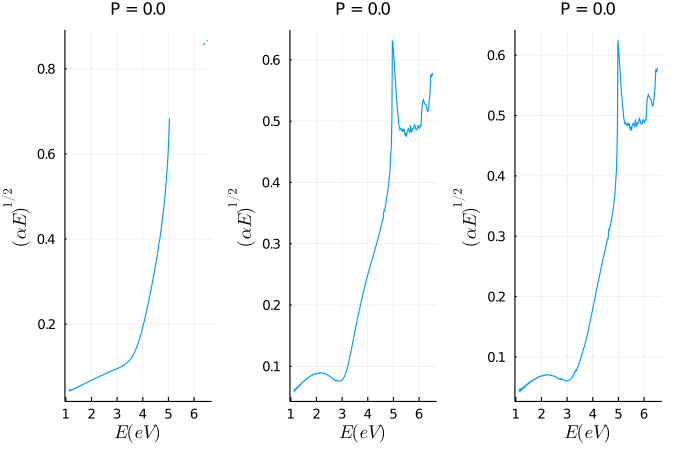

In [ ]:
presiones = ["P = $(P[1,1])" "P = $(P[1,2])" "P = $(P[1,3])"]
plot(E[:,1,:],(alfa[:,1,:].*E[:,1,:]).^0.5,dpi=450,layout=(1,3),title=presiones,xlabel=L"E(eV)",ylabel=L"(\alpha E)^{1/2}",label=false,titlefontsize=10)

In [ ]:
#Obteniendo los intervalos en los cuales la gráfica es lineal (a ojo)
intervalos_1 = zeros(3,2)   #Indice 1 = Medicion, Indice 2 = Limites
intervalos_1[1,:] = [4,4.6]
intervalos_1[2,:] = [3.3,4.5]
intervalos_1[3,:] = [3.4,4.5]

2-element Vector{Float64}:
 3.4
 4.5

In [ ]:
#Realizando el ajuste lineal
coeficientes_1 = zeros(N_mediciones[1],2)
gap_1 = zeros(N_mediciones[1])

for i in 1:N_mediciones[1]
    indices = abs.(E[:,1,i] .- mean(intervalos_1[i,:])) .<= abs(intervalos_1[i,1]-intervalos_1[i,2])/2
    x = E[indices,1,i] 
    y = (alfa[indices,1,i].*E[indices,1,i]).^0.5
    n = sum(indices)
    #Calculando los coeficientes de regresion lineal
    m = (sum(x.*y) - n*mean(x)*mean(y))/(sum(x.^2)-(sum(x))^2/n)
    b = (sum(x.^2)*sum(y)-sum(x.*y)*sum(x))/(n*sum(x.^2)-(sum(x))^2)
    coeficientes_1[i,:] = [m,b]
    gap_1[i] = -b/m
end

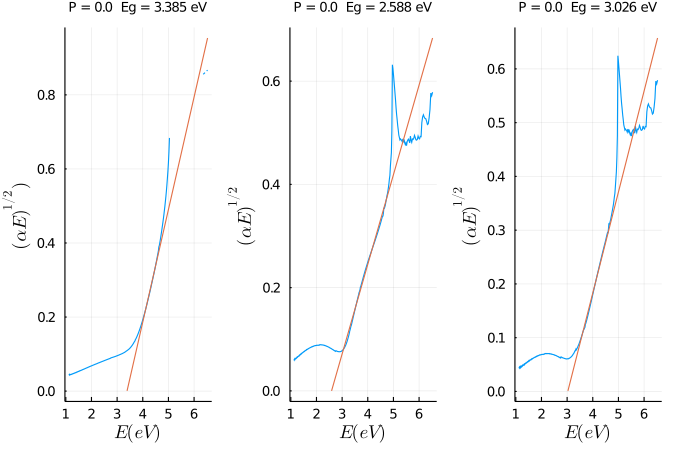

In [ ]:
#Graficando con la regresión lineal
l = @layout [a b c]
#Muestra 1
#Curva entera
p1 = plot(
    E[:,1,1], #X
    (alfa[:,1,1].*E[:,1,1]).^0.5,dpi=450, #Y
    title="$(presiones[1])  Eg = $(round(gap_1[1],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2})",
    label=false )
#Parte lineal
p1 = plot!(E[E[:,1,1].>=gap_1[1],1,1],E[E[:,1,1].>=gap_1[1],1,1].*coeficientes_1[1,1].+coeficientes_1[1,2],label=false)

#Muestra 2
#Curva entera
p2 = plot(
    E[:,1,2],
    (alfa[:,1,2].*E[:,1,2]).^0.5,
    title="$(presiones[2])  Eg = $(round(gap_1[2],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2}",
    label=false)
#Parte lineal
p2 = plot!(E[E[:,1,2].>=gap_1[2],1,2],E[E[:,1,2].>=gap_1[2],1,2].*coeficientes_1[2,1].+coeficientes_1[2,2],label=false)

#Muestra 3
#Curva entera
p3 = plot(
    E[:,1,3],
    (alfa[:,1,3].*E[:,1,3]).^0.5,
    title="$(presiones[3])  Eg = $(round(gap_1[3],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2}",
    label=false)
#Parte lineal
p3 = plot!(E[E[:,1,3].>=gap_1[3],1,3],E[E[:,1,3].>=gap_1[3],1,3].*coeficientes_1[3,1].+coeficientes_1[3,2],label=false)
#Graficando
plot(p1,p2,p3,layout=l,dpi=450,titlefontsize=8)

### Equipo 2

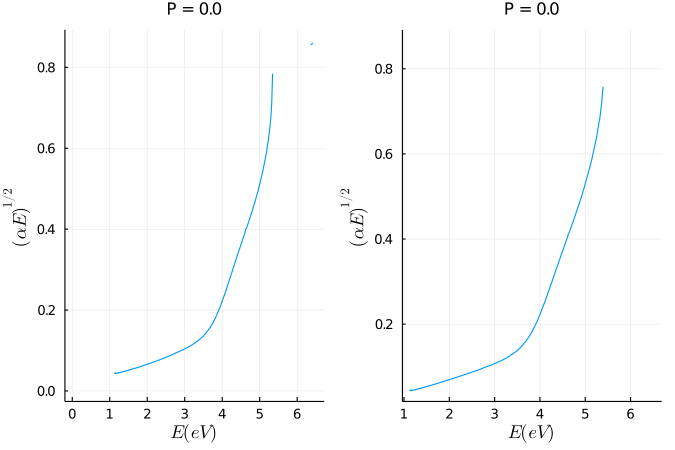

In [ ]:
presiones = ["P = $(P[2,1])" "P = $(P[2,2])" "P = $(P[2,3])"]
plot(E[:,2,:],(alfa[:,2,:].*E[:,2,:]).^0.5,dpi=450,layout=(1,2),title=presiones,xlabel=L"E(eV)",ylabel=L"(\alpha E)^{1/2}",label=false,titlefontsize=10)

In [ ]:
#Obteniendo los intervalos en los cuales la gráfica es lineal (a ojo)
intervalos_2 = zeros(2,2)   #Indice 1 = Medicion, Indice 2 = Limites
intervalos_2[1,:] = [3.9,5]
intervalos_2[2,:] = [4,5.2]

2-element Vector{Float64}:
 4.0
 5.2

In [ ]:
#Realizando el ajuste lineal
coeficientes_2 = zeros(N_mediciones[2],2)
gap_2 = zeros(N_mediciones[2])

for i in 1:N_mediciones[2]
    indices = abs.(E[:,2,i] .- mean(intervalos_2[i,:])) .<= abs(intervalos_2[i,1]-intervalos_2[i,2])/2
    x = E[indices,2,i] 
    y = (alfa[indices,2,i].*E[indices,2,i]).^0.5
    n = sum(indices)
    #Calculando los coeficientes de regresion lineal
    m = (sum(x.*y) - n*mean(x)*mean(y))/(sum(x.^2)-(sum(x))^2/n)
    b = (sum(x.^2)*sum(y)-sum(x.*y)*sum(x))/(n*sum(x.^2)-(sum(x))^2)
    coeficientes_2[i,:] = [m,b]
    gap_2[i] = -b/m
end

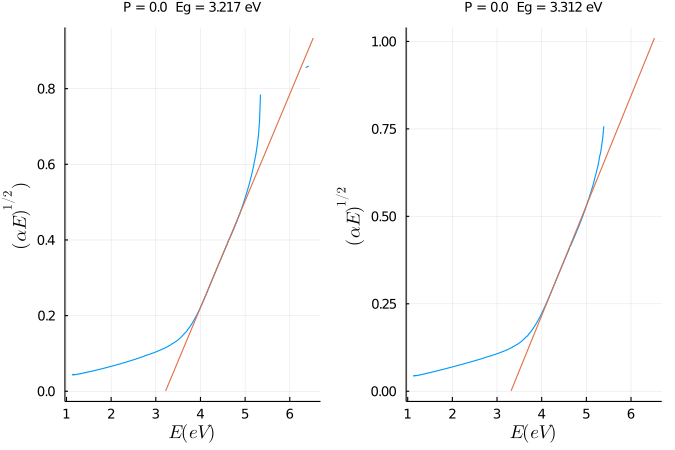

In [ ]:
#Graficando con la regresión lineal
l = @layout [a b]
#Muestra 1
#Curva entera
p1 = plot(
    E[:,2,1], #X
    (alfa[:,2,1].*E[:,2,1]).^0.5, #Y
    title="$(presiones[1])  Eg = $(round(gap_2[1],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2})",
    label=false )
#Parte lineal
p1 = plot!(E[E[:,2,1].>=gap_2[1],2,1],E[E[:,2,1].>=gap_2[1],2,1].*coeficientes_2[1,1].+coeficientes_2[1,2],label=false)

#Muestra 2
#Curva entera
p2 = plot(
    E[:,2,2],
    (alfa[:,2,2].*E[:,2,2]).^0.5,
    title="$(presiones[2])  Eg = $(round(gap_2[2],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2}",
    label=false)
#Parte lineal
p2 = plot!(E[E[:,2,2].>=gap_2[2],2,2],E[E[:,2,2].>=gap_2[2],2,2].*coeficientes_2[2,1].+coeficientes_2[2,2],label=false)

plot(p1,p2,layout=l,dpi=450,titlefontsize=8)

### Equipo 3

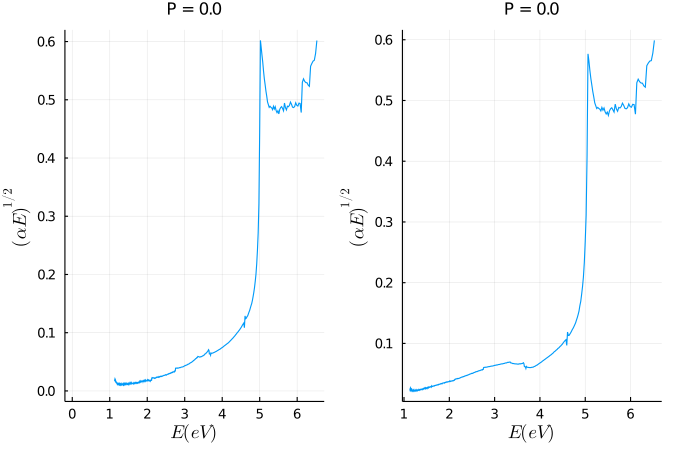

In [ ]:
presiones = ["P = $(P[3,1])" "P = $(P[3,2])" "P = $(P[3,3])"]
plot(E[:,3,:],(alfa[:,3,:].*E[:,3,:]).^0.5,dpi=450,layout=(1,2),title=presiones,xlabel=L"E(eV)",ylabel=L"(\alpha E)^{1/2}",label=false,titlefontsize=10)

In [ ]:
#Obteniendo los intervalos en los cuales la gráfica es lineal (a ojo)
intervalos_3 = zeros(2,2)   #Indice 1 = Medicion, Indice 2 = Limites
intervalos_3[1,:] = [4.9,5.05]
intervalos_3[2,:] = [4.95,5.1]

2-element Vector{Float64}:
 4.95
 5.1

In [ ]:
#Realizando el ajuste lineal
coeficientes_3 = zeros(N_mediciones[3],2)
gap_3 = zeros(N_mediciones[3])

for i in 1:N_mediciones[3]
    indices = abs.(E[:,3,i] .- mean(intervalos_3[i,:])) .<= abs(intervalos_3[i,1]-intervalos_3[i,2])/2
    x = E[indices,3,i] 
    y = (alfa[indices,3,i].*E[indices,3,i]).^0.5
    n = sum(indices)
    #Calculando los coeficientes de regresion lineal
    m = (sum(x.*y) - n*mean(x)*mean(y))/(sum(x.^2)-(sum(x))^2/n)
    b = (sum(x.^2)*sum(y)-sum(x.*y)*sum(x))/(n*sum(x.^2)-(sum(x))^2)
    coeficientes_3[i,:] = [m,b]
    gap_3[i] = -b/m
end
coeficientes_3

2×2 Matrix{Float64}:
 3.17703  -15.4281
 3.33585  -16.3784

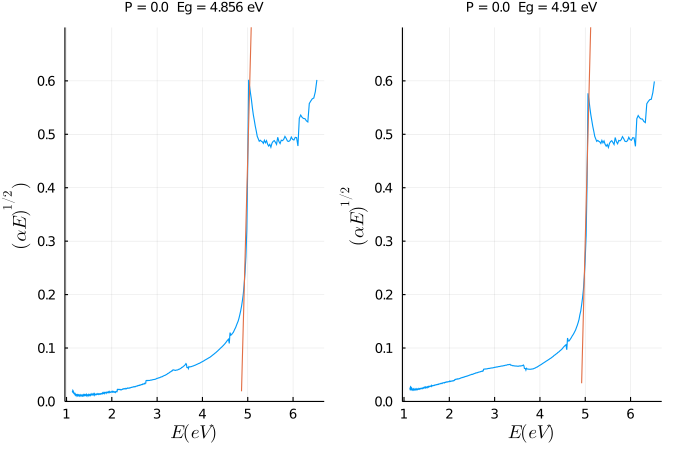

In [ ]:
#Graficando con la regresión lineal
l = @layout [a b]
#Muestra 1
#Curva entera
p1 = plot(
    E[:,3,1], #X
    (alfa[:,3,1].*E[:,3,1]).^0.5, #Y
    title="$(presiones[1])  Eg = $(round(gap_3[1],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2})",
    label=false )
#Parte lineal
p1 = plot!(E[E[:,3,1].>=gap_3[1],3,1],E[E[:,3,1].>=gap_3[1],3,1].*coeficientes_3[1,1].+coeficientes_3[1,2],label=false)

#Muestra 2
#Curva entera
p2 = plot(
    E[:,3,2],
    (alfa[:,3,2].*E[:,3,2]).^0.5,
    title="$(presiones[2])  Eg = $(round(gap_3[2],digits=3)) eV",
    xlabel=L"E(eV)",
    ylabel=L"(\alpha E)^{1/2}",
    label=false)
#Parte lineal
p2 = plot!(E[E[:,3,2].>=gap_3[2],3,2],E[E[:,3,2].>=gap_3[2],3,2].*coeficientes_3[2,1].+coeficientes_3[2,2],label=false)

plot(p1,p2,layout=l,dpi=450,titlefontsize=8,ylim=(0,0.7))